# Capstone Final Project - Medical access in Singapore
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Singapore is an island city-state off southern Malaysia where approximately 6 million people are living in. It is one of the most important hubs of Southeast Asia, it possesses the world second busiest port in the world, and it is the place of choice of many multinationals who decide to establish in Southeast Asia. 

   I just spent one year in Singapore as part of my study and through this year I worked part time with an insurance company in Singapore. Their goal was to provide very personalized insurance for expats in Singapore, because healthcare is very expensive in Singapore, there is an important need for people to choose on what they want to be insured. 
    
   Moreover it is important for people to know if there is an easy access to health services from where they live, when an expat wants to settle in a new country we want to advise him where are the neighbourhoods that are close to medical centre, hospital, doctor’s office, etc… 
    
   The problem I want to solve here is, how can I get an evaluation of the access to health services of each neighbourhood of Singapore. With this evaluation I will be able to tell if a neighbourhood is poorly provided or on the contrary has good access to any kind of health services. 


## Data <a name="data"></a>

In order to solve this problematic I used the data listed below:
-	First to get the name of every neighbourhood of Singapore, I went of the Wikipedia page listing all the postal code of Singapore, I saw that they provided a tab containing every postal district with their neighbourhoods in Singapore. https://en.wikipedia.org/wiki/Postal_codes_in_Singapore
-	In order to get the geolocation of every neighbourhood of Singapore, I used the geocoder library
-	I used the Foursquare API to get all the healthcare services around each neighbourhood


### Import necessary Libraries

In [132]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

from bs4 import BeautifulSoup #library for beautifulSoup

%matplotlib inline 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
import geocoder # import geocoder
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Define Foursquare Credentials and Version

In [130]:
CLIENT_ID = '5VJF3VBFRZMHIDSIWM0HJAEL4FTSFUUUQZLEMDRFY1NE3PIU' # your Foursquare ID
CLIENT_SECRET = 'RUDPD2H4ZX0DTPC3CH0A0MHTZQKFX4HPSFNIU3FVII3OLK3C' # your Foursquare Secret
VERSION = '20190518'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5VJF3VBFRZMHIDSIWM0HJAEL4FTSFUUUQZLEMDRFY1NE3PIU
CLIENT_SECRET:RUDPD2H4ZX0DTPC3CH0A0MHTZQKFX4HPSFNIU3FVII3OLK3C


## 1. Scrapping of the wikipedia page containing all the post code of Singapore

The goal here is to retrieve all the neighbourhood from the wikipedia page and get their geolocation 

In [302]:
url = "https://en.wikipedia.org/wiki/Postal_codes_in_Singapore"

#Get the content of the wiki page on a string
results = requests.get(url).text

#Transform the content in xml with BeautifulSoup
page = BeautifulSoup(results, "lxml")

tab = page.tbody

#We remove the link present in the page
for a in tab.findAll('a'):
    a.replaceWithChildren()

### Create the Dataframe that will contain postcodes

In [321]:
postal_code = pd.DataFrame(columns=['Postal District', 'Neighborhood'])
postal_code

,Postal District,Neighborhood


### Fill the Dataframe with the postcodes

In [322]:
count = 0
for row in tab.find_all('tr'):
    postDistrict = row.contents[1].string
    neighborhood_name = row.contents[5].string
    if(neighborhood_name == None):
        neighborhood_name2 = row.contents[5].contents
        neighborhood_name2 = [x for x in neighborhood_name2 if (x != ', ' and x != '\n')]
    else:
        neighborhood_name2 = neighborhood_name.split(',')
    
    for ele in neighborhood_name2:
        postal_code = postal_code.append({'Postal District': postDistrict,
                                      'Neighborhood': ele},
                                      ignore_index=True)
    
#Remove all space and '\n' in the dataFrame
postal_code['Neighborhood'] = postal_code['Neighborhood'].str.strip()
#remove first line of the dataframe
postal_code = postal_code[1:]
postal_code.head(10)

,Postal District,Neighborhood
1,01,Raffles Place
2,01,Cecil
3,01,Marina
4,01,People's Park
5,02,Anson
6,02,Tanjong Pagar
7,03,Bukit Merah
8,03,Queenstown
9,03,Tiong Bahru
10,04,Telok Blangah


In [323]:
postal_code.shape

(75, 2)

### Get the location of every district of Singapore using geolocator

In [310]:
geolocator = Nominatim(user_agent="singap_agent")

print('Obtaining neighborhood geolocationn:', end='')

for index in postal_code.index:
    print(' .', end='')
    overtime = 0
    location = None
    address = postal_code.loc[index, 'Neighborhood'] + ', Singapore, SG'
    while(location is None and overtime < 3):
        location = geolocator.geocode(address)
        #after 3 try, we give up the geolocalisation
        overtime +=1
    if(location != None):
        postal_code.loc[index, 'Latitude'] = location.latitude
        postal_code.loc[index, 'Longitude'] = location.longitude
    else:
        postal_code.loc[index, 'Latitude'] = None
        postal_code.loc[index, 'Longitude'] = None
        
#We remove the districts we couldn't locate
postal_code.dropna(axis=0, inplace = True)
print(' done.')

In [311]:
postal_code.head()

,Postal District,Neighborhood,Latitude,Longitude
1,01,Raffles Place,1.283595,103.851568
2,01,Cecil,1.278716,103.847738
3,01,Marina,1.290475,103.852036
4,01,People's Park,1.285810,103.844160
5,02,Anson,1.271363,103.842698
6,02,Tanjong Pagar,1.276571,103.845848
7,03,Bukit Merah,1.280628,103.830591
8,04,Telok Blangah,1.270586,103.809863
9,04,Harbourfront,1.265451,103.822652
10,05,Pasir Panjang,1.288834,103.775657


### Exploration of the neighborhoods in Singapore

In [180]:
address = 'Singapore, SG'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

1.3408528 103.878446863736


In [206]:
# create map of Singapore using latitude and longitude values
map_singapore = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, postcode, neighborhood in zip(postal_code['Latitude'], postal_code['Longitude'], postal_code['Postal District'], postal_code['Neighborhood']):
    label = '{}, {}'.format(postcode, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)
    
map_singapore

Let's save the file so we can use again the data for our project without having to execute the search again

In [316]:
postal_code.to_csv('Singapore_neighborhood_geolocalisation.csv', index = False)

## 2. Retrieve healthcare category id 

#### This part is not used in the end because I found later the approriate category Id directly from the Foursquare website (https://developer.foursquare.com/docs/resources/categories)

The goal here is to retrieve the differents categoryId linked to an healthcare place to do a specific search on them. We are going to start utilizing the Foursquare API to explore the venues in Singapore and only keep the one related to healthcare.

### Search for a doctor in Singapore

We explore in a large area in Singapore everything related to 'doctor' or 'clinic'

In [8]:
search_query = 'clinic'
radius = 50000

In [9]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

#### Get the result in JSON and transform it into a *pandas* dataframe

In [10]:
results = requests.get(url).json()
# assign relevant part of JSON to venues
venues = results['response']['venues']
dataframe = json_normalize(venues)


In [19]:
categorie = pd.DataFrame()

# function that extracts the category of the venue
def get_category_type(row, col):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        if(col == 'i'):
            return categories_list[0]['id']
        if(col == 'c'):
            return categories_list[0]['name']

# filter the category and categoryId for each row
categorie['id'] = dataframe.apply(get_category_type, axis=1, args=('i'))
categorie['categories'] = dataframe.apply(get_category_type, axis=1, args=('c'))


#### Obtain all different kind of medical offices in Singapore 

I see that I obtain seven different kind of healthcare place, I remove the category 'Building'

In [34]:
categorie = categorie[categorie.categories != 'Building']
healthcare_categoriyId = categorie.groupby(['id','categories']).count()
healthcare_categoriyId

I save the different categoryId in a file that I will use later

In [42]:
healthcare_categoriyId.to_csv('Singapore_healthcare_categoriyId.csv')

## Methodology <a name="methodology"></a>

## 3. Explore Neighborhoods in Singapore

#### Let's create a function to explore healthcare places in all the neighborhoods in Singapore

In [4]:
postal_code = pd.read_csv('Singapore_neighborhood_geolocalisation.csv')
healthcare_categoriyId = pd.read_csv('Singapore_healthcare_categoriyId.csv')

In [5]:
def getMedicalVenues(postal_district, names, latitudes, longitudes, radius=500):
    #I directly put the category medical center from foursquare website
    categories = '4bf58dd8d48988d104941735'
    #for id in healthcare_categoriyId.id:
     #   categories = categories + ','+ id
    #categories = categories[1:]
    print('Obtaining medical venues around Neighborhood:', end='')
    venues_list=[]
    for postal_district, name, lat, lng in zip(postal_district, names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            categories,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        #print(results)
        # return only relevant information for each nearby venue
        venues_list.append([(
            postal_district,
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal_District',
              'Neighborhood',
              'Neighborhood_Latitude', 
              'Neighborhood_Longitude', 
              'Venue', 
              'lat', 
              'lng', 
              'Category']
    
    print(' done.')
    return(nearby_venues)

In [6]:
medical_venues = getMedicalVenues(postal_district = postal_code['Postal District'],
                                   names=postal_code['Neighborhood'],
                                   latitudes=postal_code['Latitude'],
                                   longitudes=postal_code['Longitude']
                                  )

Raffles Place
Cecil
Marina
People's Park
Anson
Tanjong Pagar
Bukit Merah
Queenstown
Tiong Bahru
Telok Blangah
Harbourfront
Pasir Panjang
High Street
Middle Road
Golden Mile
Little India
Farrer Park
Jalan Besar
Lavender
Orchard
Cairnhill
River Valley
Ardmore
Bukit Timah
Holland Road
Tanglin
Watten Estate
Novena
Thomson
Balestier
Toa Payoh
Serangoon
Macpherson
Braddell
Geylang
Eunos
Katong
Joo Chiat
Amber Road
Bedok
Upper East Coast
Eastwood
Kew Drive
Loyang
Changi
Simei
Tampines
Pasir Ris
Serangoon Garden
Hougang
Punggol
Bishan
Ang Mo Kio
Upper Bukit Timah
Clementi Park
Ulu Pandan
Jurong
Tuas
Hillview
Dairy Farm
Bukit Panjang
Choa Chu Kang
Lim Chu Kang
Tengah
Kranji
Woodgrove
Woodlands
Upper Thomson
Springleaf
Yishun
Sembawang
Seletar


In [25]:
medical_venues.head()

,Postal_District,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,lat,lng,Category
0,1,Raffles Place,1.283595,103.851568,In Touch Physio,1.283503,103.851163,Medical Center
1,1,Raffles Place,1.283595,103.851568,Fullerton Healthcare,1.283049,103.851697,Medical Center
2,1,Raffles Place,1.283595,103.851568,Oc Medical Raffles Place,1.284126,103.851050,Medical Center
3,1,Raffles Place,1.283595,103.851568,Lee & Lee (Dental Surgeons) Pte Ltd,1.282806,103.851980,Dentist's Office
4,1,Raffles Place,1.283595,103.851568,Raffles Medical Centre,1.284661,103.851553,Medical Center


#### I chose to keep only the five most common medical venues for the analysis 

In [8]:
med_venues = medical_venues.loc[medical_venues['Category'].isin(["Dentist's Office", "Doctor's Office",'Hospital', 'Emergency Room','Medical Center'])]

In [9]:
med_venues.groupby(['Category']).count()

,Postal_District,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,lat,lng
Category,,,,,,,
Dentist's Office,293,293,293,293,293,293,293
Doctor's Office,753,753,753,753,753,753,753
Emergency Room,35,35,35,35,35,35,35
Hospital,297,297,297,297,297,297,297
Medical Center,543,543,543,543,543,543,543


In [10]:
print('There are {} uniques categories.'.format(len(med_venues['Category'].unique())))

There are 5 uniques categories.


## 4. Analysis of each Neighborhood of Singapore <a name="analysis"></a>

In [148]:
# one hot encoding
med_onehot = pd.get_dummies(med_venues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
med_onehot['Neighborhood'] = med_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [med_onehot.columns[-1]] + list(med_onehot.columns[:-1])
med_onehot = med_onehot[fixed_columns]

med_onehot.head()

,Neighborhood,Dentist's Office,Doctor's Office,Emergency Room,Hospital,Medical Center
0,Raffles Place,0,0,0,0,1
1,Raffles Place,0,0,0,0,1
2,Raffles Place,0,0,0,0,1
3,Raffles Place,1,0,0,0,0
4,Raffles Place,0,0,0,0,1


#### Next, let's group rows by neighborhood and by taking the sum of the frequency of occurrence of each category

Because the research didn't always return venues, we are missing some neighborhood, for this reason, I add the missing neighborhood at the end of the dataframe with 0 venues

In [149]:
med_grouped_sum = med_onehot.groupby('Neighborhood').sum().reset_index()
#Get the missing neighborhood
missing_neigh = postal_code.loc[~postal_code['Neighborhood'].isin(med_grouped_sum['Neighborhood'])]['Neighborhood']

#add these neighborhood to the grouped df with 0 occurence of each medical venues
for neighborhood in missing_neigh:
        med_grouped_sum = med_grouped_sum.append({'Neighborhood': neighborhood,
                                          "Dentist's Office":0,
                                          "Doctor's Office":0,
                                          'Emergency Room':0,
                                          'Hospital':0,
                                          'Medical Center':0},ignore_index=True)
med_grouped_sum

,Neighborhood,Dentist's Office,Doctor's Office,Emergency Room,Hospital,Medical Center
0,Amber Road,6,19,1,1,5
1,Ang Mo Kio,8,15,0,1,21
2,Anson,7,17,0,0,6
3,Ardmore,11,12,0,1,19
4,Balestier,0,4,3,29,5
5,Bedok,14,14,0,0,18
6,Bishan,10,19,0,2,13
7,Braddell,1,3,0,0,4
8,Bukit Merah,0,4,1,29,6
9,Bukit Panjang,3,12,1,2,7


#### Let's Visualize the numbers of medical venues around each neighborhood

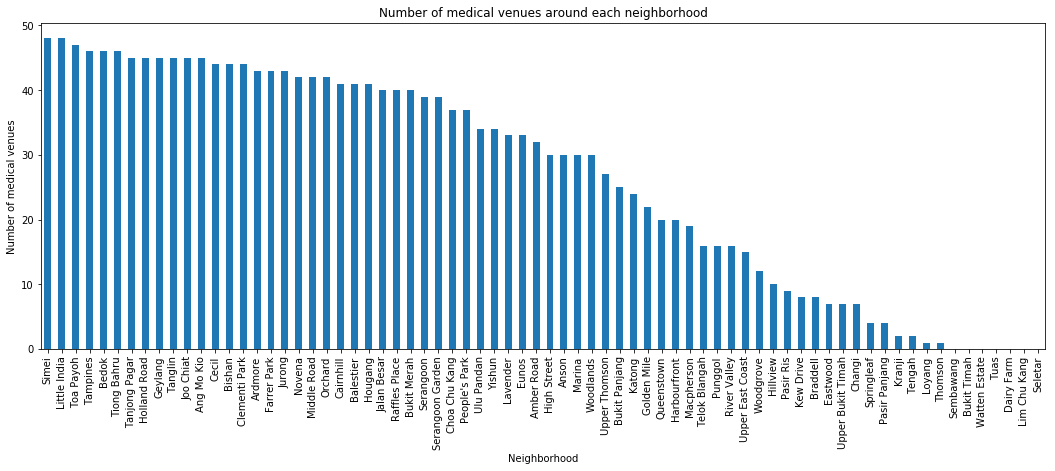

In [164]:
#Collect data
med_venues_visu = med_venues.groupby(['Neighborhood']).count()
med_venues_visu = med_venues_visu['Postal_District']
#Add neighborhood with 0 venues 
for neighborhood in missing_neigh:
        med_venues_visu = med_venues_visu.append(pd.Series([0], index=[neighborhood]))
med_venues_visu = med_venues_visu.sort_values(ascending=False)

# plot data
med_venues_visu.plot(kind='bar', figsize=(18, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of medical venues') # add y-label to the plot
plt.title('Number of medical venues around each neighborhood') # add title to the plot

plt.show()

#not relevant ...
<!--
med_grouped = med_onehot.groupby('Neighborhood').mean().reset_index()

missing_neigh = postal_code.loc[~postal_code['Neighborhood'].isin(med_grouped['Neighborhood'])]['Neighborhood']

for neighborhood in missing_neigh:
        med_grouped = med_grouped.append({'Neighborhood': neighborhood,
                                          "Dentist's Office":0,
                                          "Doctor's Office":0,
                                          'Emergency Room':0,
                                          'Hospital':0,
                                          'Medical Center':0},ignore_index=True)
med_grouped.head()
--> 

### Data Normalization

In [66]:
# we remove neighborhood column from the dataframe to do the normalization
values =  med_grouped_sum[med_grouped_sum.columns[1:]]
med_grouped_sum_norm = (values - values.mean()) / (values.max() - values.min())

# add neighborhood column back to dataframe
med_grouped_sum_norm['Neighborhood'] = med_grouped_sum['Neighborhood']
# move neighborhood column to the first column
fixed_columns = [med_grouped_sum_norm.columns[-1]] + list(med_grouped_sum_norm.columns[:-1])
med_grouped_sum_norm = med_grouped_sum_norm[fixed_columns]

med_grouped_sum_norm.head()

,Neighborhood,Dentist's Office,Doctor's Office,Emergency Room,Hospital,Medical Center
0,Amber Road,0.137897,0.305060,0.171296,-0.097656,-0.121032
1,Ang Mo Kio,0.280754,0.162202,-0.162037,-0.097656,0.640873
2,Anson,0.209325,0.233631,-0.162037,-0.128906,-0.073413
3,Ardmore,0.495040,0.055060,-0.162037,-0.097656,0.545635
4,Balestier,-0.290675,-0.230655,0.837963,0.777344,-0.121032
5,Bedok,0.709325,0.126488,-0.162037,-0.128906,0.498016
6,Bishan,0.423611,0.305060,-0.162037,-0.066406,0.259921
7,Braddell,-0.219246,-0.266369,-0.162037,-0.128906,-0.168651
8,Bukit Merah,-0.290675,-0.230655,0.171296,0.777344,-0.073413
9,Bukit Panjang,-0.076389,0.055060,0.171296,-0.066406,-0.025794


#### Let's just see which are the most common medical venues around each area

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [191]:
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = med_grouped['Neighborhood']

for ind in np.arange(med_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(med_grouped_sum_norm.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Amber Road,Doctor's Office,Emergency Room,Dentist's Office,Hospital,Medical Center
1,Ang Mo Kio,Medical Center,Dentist's Office,Doctor's Office,Hospital,Emergency Room
2,Anson,Doctor's Office,Dentist's Office,Medical Center,Hospital,Emergency Room
3,Ardmore,Medical Center,Dentist's Office,Doctor's Office,Hospital,Emergency Room
4,Balestier,Emergency Room,Hospital,Medical Center,Doctor's Office,Dentist's Office


## 5. Cluster Neighborhoods

#### Evaluation through the Elbow method

A way to choose the correct number of cluster is to use the Elbow method. I ploted the distortion that we obtain after running the Kmeans algorithm with different number of cluster. 
As we can see on the graph, there is not a clear elbow point, where the distortion goes down rapidly until a certain point and then the distortion goes down very slowly. 
So we can't really evaluate what would be the most appropriate number of clusters. 

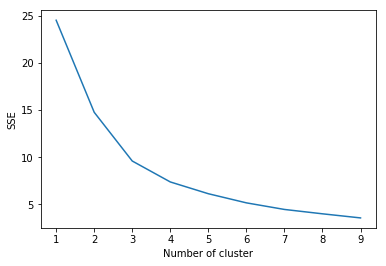

In [165]:
sse = {}
for k in range(1, 10):
    kmeans2 = KMeans(n_clusters=k, max_iter=1000).fit(med_grouped_clustering)
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans2.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

The evaluation being not relevant, I decided to run *k*-means to cluster the neighborhood into 5 clusters.
I choose to have a lot of clusters to obtain a better differentitation to know which area was poorly surrounded by medical venues. 
With 4 clusters some areas that I judge enough surrounded were in the same cluster than some areas very poorly surrounded by medical venues

In [192]:
# set number of clusters
kclusters = 5

med_grouped_clustering = med_grouped_sum_norm.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(med_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 1, 4, 1, 1, 2, 4, 0])

Let's create a new dataframe that includes the cluster as well as the top venues for each neighborhood.

In [193]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

medic_singap_merged = postal_code

# merge neighborhoods_venues_sorted with medic_singap_merged to add latitude/longitude for each neighborhood
medic_singap_merged = medic_singap_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

medic_singap_merged.head() 

,Postal District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Raffles Place,1.283595,103.851568,1,Dentist's Office,Doctor's Office,Medical Center,Hospital,Emergency Room
1,1,Cecil,1.278716,103.847738,1,Medical Center,Dentist's Office,Doctor's Office,Hospital,Emergency Room
2,1,Marina,1.290475,103.852036,1,Dentist's Office,Medical Center,Doctor's Office,Hospital,Emergency Room
3,1,People's Park,1.285810,103.844160,1,Medical Center,Doctor's Office,Dentist's Office,Hospital,Emergency Room
4,2,Anson,1.271363,103.842698,0,Doctor's Office,Dentist's Office,Medical Center,Hospital,Emergency Room


#### Let's add a new cluster label for the neighborhood that have not a single medical venue around them

In [194]:
for index in medic_singap_merged.index:
    #print(missing_neigh.values)
    if (medic_singap_merged.iloc[index]['Neighborhood'] in missing_neigh.values):
        medic_singap_merged.loc[index, 'Cluster Labels'] = 5

Finally, let's visualize the resulting clusters

In [200]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# I set the color in function of my analysis in order to have an easier interpretation 
rainbow = ['yellowgreen', 'green','red','green','blue','darkred']

# add markers to the map
markers_colors = []
for lat, lon, postal, nei, cluster in zip(medic_singap_merged['Latitude'], medic_singap_merged['Longitude'],medic_singap_merged['Postal District'], medic_singap_merged['Neighborhood'], medic_singap_merged['Cluster Labels']):
    label = folium.Popup(str(postal) + ', ' +str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We will merge the number of venues to the result to interpret

In [196]:
medic_singap_merged2 = medic_singap_merged.join(med_grouped_sum.set_index('Neighborhood'), on='Neighborhood')
medic_singap_merged2

,Postal District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Dentist's Office,Doctor's Office,Emergency Room,Hospital,Medical Center
0,1,Raffles Place,1.283595,103.851568,1,Dentist's Office,Doctor's Office,Medical Center,Hospital,Emergency Room,9,18,0,0,13
1,1,Cecil,1.278716,103.847738,1,Medical Center,Dentist's Office,Doctor's Office,Hospital,Emergency Room,9,19,0,1,15
2,1,Marina,1.290475,103.852036,1,Dentist's Office,Medical Center,Doctor's Office,Hospital,Emergency Room,9,10,0,2,9
3,1,People's Park,1.285810,103.844160,1,Medical Center,Doctor's Office,Dentist's Office,Hospital,Emergency Room,4,19,0,0,14
4,2,Anson,1.271363,103.842698,0,Doctor's Office,Dentist's Office,Medical Center,Hospital,Emergency Room,7,17,0,0,6
5,2,Tanjong Pagar,1.276571,103.845848,1,Dentist's Office,Medical Center,Doctor's Office,Hospital,Emergency Room,11,19,0,1,14
6,3,Bukit Merah,1.280628,103.830591,4,Hospital,Emergency Room,Medical Center,Doctor's Office,Dentist's Office,0,4,1,29,6
7,3,Queenstown,1.294623,103.806045,0,Hospital,Medical Center,Doctor's Office,Dentist's Office,Emergency Room,2,8,0,4,6
8,3,Tiong Bahru,1.286197,103.825765,3,Emergency Room,Medical Center,Doctor's Office,Dentist's Office,Hospital,6,17,2,5,16
9,4,Telok Blangah,1.270586,103.809863,0,Dentist's Office,Doctor's Office,Hospital,Emergency Room,Medical Center,4,10,0,0,2


Analysis of the result :
- 0 : Well deserved by Dentist and doctor offices and medical centers
- 1 : Very well surounded by Dentist and doctor offices and medical centers
- 2 : Lack of medical services compare to the other area
- 3 : Very well surounded by Dentist and doctor offices and medical centers
- 4 : Neighborhood with lot of hospitals compare to the other area
- 5 : Not a single medical place is present around there

## Results and Discussion <a name="results"></a>

## Conclusion <a name="conclusion"></a>

In [43]:
venues_map = folium.Map(location=[nearby_venues.iloc[0]['Neighborhood_Latitude'], nearby_venues.iloc[0]['Neighborhood_Longitude']], zoom_start=14) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.features.CircleMarker(
    [nearby_venues.iloc[0]['Neighborhood_Latitude'], nearby_venues.iloc[0]['Neighborhood_Longitude']],
    radius=5,
    color='red',
    popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, neighborhood, category in zip(nearby_venues.lat, nearby_venues.lng, nearby_venues.Neighborhood, nearby_venues.Category):
    label = '{}, {}'.format(neighborhood, category)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map